# Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · September 2018 (actualizado en Febrero 2026) · 5 min read

---

# Resumen

La detección de anomalías es un campo que busca modelar el comportamiento de los sistemas para emitir alertas automáticas cuando existen desviaciones y así prevenir fallas catastróficas. Aunque el uso de aprendizaje por computadora se ha vuelto popular para detectar este tipo de anomalías, existen otros métodos computacionalmente menos costosos y con un buen desempeño; tal es el caso de la media móvil (MA, por sus siglas en inglés), que describimos en el presente notebook. Proponemos además un ejemplo de tiempos de respuesta en un servidor web de facturas electrónicas sobre su aplicación y explicamos cómo elegir un tamaño de ventana de la MA para evitar falsos positivos y retrasos en la emisión de las alertas.

# Historia
Actualmente, recibir un tiquete electrónico al realizar una compra en Costa Rica ocurre casi de forma inmediata, pero esto no fue así en el pasado. Más exactamente, en septiembre de 2018, cuando unos 156.965 contribuyentes en todo el país migraron al nuevo sistema, se tardaba hasta 47 segundos solo para recibir la aprobación del tiquete por parte del Ministerio de Hacienda. En ese momento muchos comercios llegaron a pensar que había problemas en el sistema, pero no fue así, sino que 47 segundos estaba por debajo del umbral de tres horas permitido en la legislación. ¿Cómo habrá sido para los equipos técnicos monitorear el tráfico web y detectar una anomalía?. A continuación presentamos un caso hipotético de cómo podría haber funcionado un sistema de emisión de alerta de tiempo de respuesta usando la media móvil para el escenario descrito [4]. 

![](../img/pexels-imin-technology-276315592-12935062_small.jpg)

# Un caso de ejemplo
Supongamos que los tiempos de respuesta de aprobación del tiquete electrónico pueden modelarse, usando un proceso normal de media $\mu=5$ minutos y varianza $\sigma^2=900$ minutos. Supongamos también que se envía una alerta cuando algún tiempo de respuesta sobrepasa el umbral de 180 minutos.

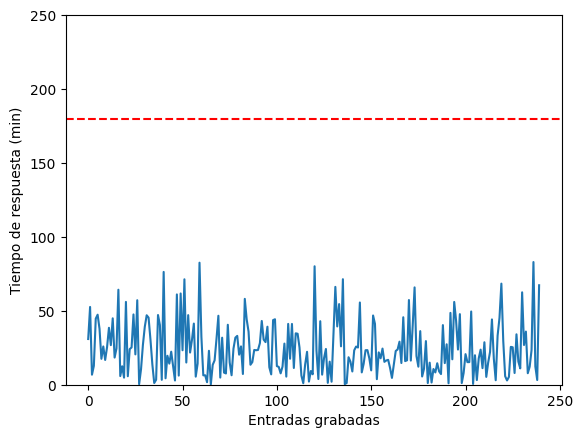

In [5]:
import matplotlib.pylab as plt
import numpy as np;

def graficar_senial(x):
    plt.figure()
    plt.plot(x,'tab:blue')
    plt.axhline(y=180, color='r', linestyle='--')
    plt.ylim([0, 250])
    plt.xlabel('Entradas grabadas')
    plt.ylabel('Tiempo de respuesta (min)')
    plt.show()

Ts = 5.0*60.0 # periodo de muestreo (en segundos)
D = 20*60.0*60.0 # duración de la señal (en segundos)
N = int(D/Ts)
mu, sigma = 5, 30
x = np.abs(np.random.normal(mu, sigma, N))
graficar_senial(x)

Ahora imaginemos que suceden dos eventos atípicos en los minutos 25-85 y 200:

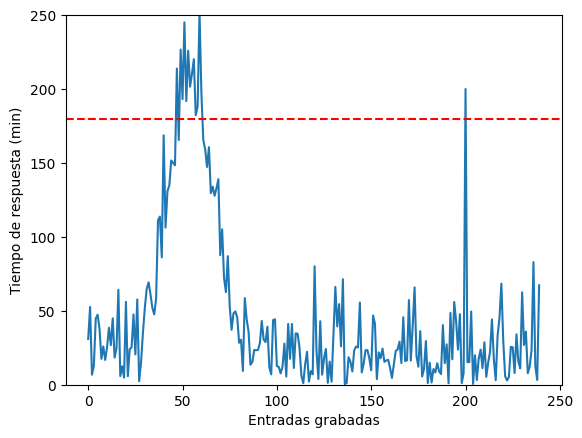

In [6]:
n0=25
x[n0:n0+60] += 180*np.hanning(60)
x[200] = 200
graficar_senial(x)

Ambos eventos anormales sobrepasan el límite máximo permitido de 180 minutos (tres horas), pero solo el primero amerita la emisión de una alerta por ser constante en el tiempo. El segundo puede ignorarse pues es más bien un *evento transitorio* o de corta duración (frecuencias altas). En este sentido, el control por umbral fijo no funciona correctamente, pues emitiría alertas en ambos casos. Una solución sería usar la media móvil, un tipo de filtro "pasa bajas" o de frecuencias bajas.

# Media móvil
La media móvil -también llamada _integral con fuga_- se define mediante la siguiente ecuación [2]:
$$
    y[n] = \frac{1}{M}\sum_{m=0}^{M}{x[n-m]}\quad (1),
$$
donde $M$ es la cantidad de vecinos de la ventana de análisis (en número de muestras) y $n$ es el índice de la posición actual de la señal. Se dice _con fuga_ porque el intervalo de integración es finito y se desplaza en función de la muestra analizada. 

Para obtener la función a procesar, el número de muestras se obtiene multiplicando la frecuencia de muestreo $F_s$ por la duración de la señal (en segundos); en nuestra señal de ejemplo de 250 muestras, la duración sería $250 \cdot 60 = 15000$ segundos ($F_s=1/60$). No se consideran los vecinos posteriores a la muestra actual, pues el procesamiento se realiza de manera causal, es decir, que no se emplean muestras que no han sido grabadas. Eligiendo arbitrariamente $M=20$ vecinos/muestras, la ecuación anterior permite obtener la siguiente versión suavizada:

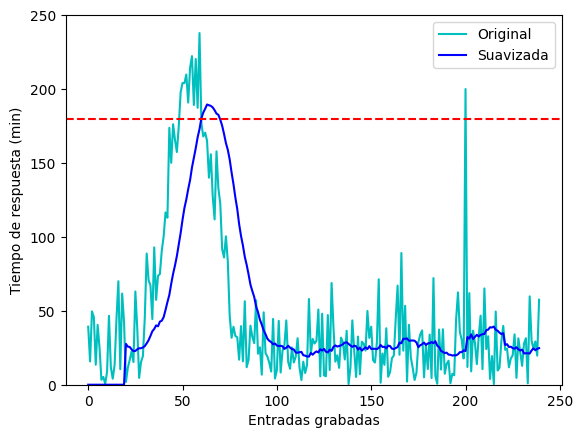

In [2]:
def graficar_seniales(x:np.ndarray, y:np.ndarray):
    plt.figure()
    plt.plot(x,'c',label='Original')
    plt.plot(y,'blue',label='Suavizada')
    plt.legend()
    plt.axhline(y=180, color='r', linestyle='--')
    plt.ylim([0, 250])
    plt.xlabel('Entradas grabadas')
    plt.ylabel('Tiempo de respuesta (min)')
    plt.show()

def ma(x:np.ndarray, M:int) -> np.ndarray:
    N = len(x)
    y = [0.0]*N
    for n in range(M,N):
        y[n] = np.sum(x[n-M:n])/M
    return y

graficar_seniales(x, ma(x, 20))

Como se observa en la gráfica, la anomalía en el rango de 25 a 85 es conservada y el pico en el instante 200 es eliminado, como se deseaba. La media móvil es una función empleada en plataformas de monitoreo del rendimiento de los sistemas, como New Relic o Graphene [7, 8]

# Retraso temporal

Un problema del procesamiento anterior es que la señal suavizada está retrasada (o desplazada a la derecha) respecto de la señal original y esto se conoce como *retraso de grupo*. El retraso de grupo es determinado por el tamaño de la ventana de análisis, donde una ventana pequeña produce un retraso de grupo corto, es decir, que las alertas se generan rápidamente pero con un mayor número de falsos positivos; por el contrario, una ventana de análisis grande brinda un mejor filtrado de las frecuencias altas pero produce un retraso de grupo largo. 

El retraso de grupo se puede expresar en términos temporales multiplicando el periodo de muestreo $T_s$ (el inverso de la frecuencia de muestreo $T_s=1/F_s$) por el tamaño de la ventana, es decir, $MT_s$ [2]. Con $M=20$ y nuestro periodo de muestreo de $T_s=1$ minuto se obtiene un retraso de grupo de 20 minutos, mientras que con $M=3$ el retraso de grupo se reduce a 3 minutos. El retraso de grupo también puede reducirse aumentando el periodo de muestreo, pero esto significa generar más datos, lo que podría aumentar los gastos en almacenamiento. A continuación, presentamos el mismo procesamiento anterior pero con un tamaño de ventana de $M=3$:

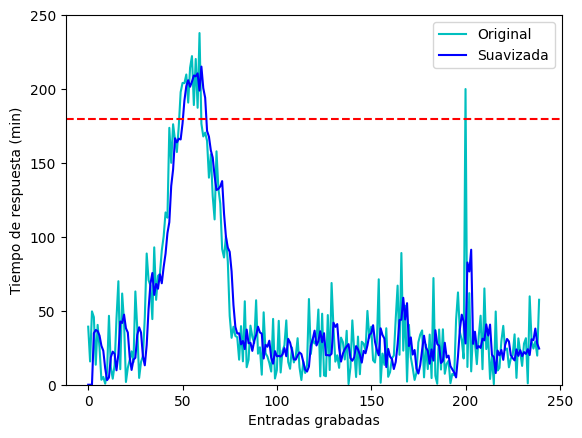

In [3]:
graficar_seniales(x, ma(x, 3))

Con una ventana de análisis más pequeña se observa en la gráfica de arriba que el filtrado sigue siendo útil y que la señal suavizada está menos desplazada respecto de la original; lo cual es conveniente.

# Inteligencia artificial
Como se mencionó al inicio del notebook, otra alternativa para realizar detección de anomalías sería usar aprendizaje por computadora, pero esto es costoso computacionalmente y ocupa grandes volúmenes de datos. Un ejemplo es el uso de encoders, un tipo de red neuronal entrenada para generar una salida idéntica a los datos de entrada; entonces se entrena el modelo con datos de cuando el sistema está estable para luego calcular el error mínimo cuadrado (MSE, por sus siglas en inglés) entre la señal real y la señal simulada, y emitir una alerta cuando el MSE sobrepasa un umbral previamente establecido [6].

# Conclusiones
La media móvil es un tipo de filtro pasa-bajas que puede emplearse en la detección de anomalías de un sistema de manera más económica que otros métodos de aprendizaje por computadora. Al usar la media móvil es necesario optimizar el tamaño de ventana según la frecuencia de muestreo de la señal y el umbral máximo para la métrica elegida (por ejemplo, el tiempo de respuesta de un servidor web). El tamaño de la ventana determina el retraso de grupo de la media móvil, donde una ventana pequeña produce un retraso de grupo corto pero con un mayor número de falsos positivos, mientras que una ventana de análisis grande brinda un mejor filtrado pero produce un retraso de grupo largo (las alertas se generan de forma tardía). Como trabajo futuro se propone investigar métodos para calcular el tamaño de ventana automáticamente, para evitar realizar prueba y error.

# Referencias
1. Brian Jackson. How to Effectively Monitor and Scale for Website Traffic. KeyCDN. 10 de enero de 2017. URL: https://www.keycdn.com/blog/scale-website-traffic/ (última vez consultado el 16 de setiembre de 2018)
2. John G. Proakis y Dimitris K. Manolakis. Digital Signal Processing (4 edición). Prentice-Hall, Inc., Upper Saddle River, NJ, USA. 2006
3. Derek Kraan. Why is my site slow if New Relic says it's fast? Request Queueing. URL: https://img.springe.st/2013_11_26_10_40_22_zdspb.jpg (última vez consultado el 20 de setiembre de 2018)
4. Carlos Cordero. Sistema de factura electrónica falló el día que recibía a nuevo grupo de contribuyentes. La República, tecnología. URL: https://www.elfinancierocr.com/tecnologia/sistema-de-factura-electronica-fallo-el-dia-que/OQ42RGIS2NFPHD2UDAGI66KNQM/story/ (última vez consultado el 23 de setiembre de 2018)
5. Ministerio de Hacienda, Dirección General de Tributación. Comprobantes electrónicos, resolución Nº DGT-R-48-2016. Gobierno de Costa Rica. URL: https://tribunet.hacienda.go.cr/docs/esquemas/2016/v4/Resolucion%20Comprobantes%20Electronicos%20%20DGT-R-48-2016.pdf (última vez consultado el 24 de setiembre de 2018)
6. Brian Douglas. Introduction to Anomaly Detection for Engineers. Mathworks. URL: https://www.mathworks.com/videos/introduction-to-anomaly-detection-for-engineers-1663930223584.html (consultado por última vez el 1 de julio de 2025).
7. New Relic. Use sliding windows for smoother charts. URL: https://docs.newrelic.com/docs/nrql/using-nrql/create-smoother-charts-sliding-windows/ (consultado por última vez el 5 de julio del 2025).
8. Graphite. Functions. URL: https://graphite.readthedocs.io/en/latest/functions.html#graphite.render.functions.movingAverage (consultado por última vez el 5 de julio de 2025).

# Creditos de la imagen
* iMin Technology. https://www.pexels.com/photo/a-close-up-shot-of-a-person-holding-a-payment-terminal-12935062/ (image free to use).

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="../img/80x15.png" /></a><p style="text-align: center;"> Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">licencia Creative Commons Atribución 4.0 Internacional</a>. El sitio <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> es un blog costarricence dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar la fuente puede usar Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = {Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica},
  year = 2018,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html},
  urldate = {}
}
```

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 2; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>